# 어떤 features가 Overffing이 되는 걸까요?

출처: [https://towardsdatascience.com/which-of-your-features-are-overfitting-c46d0762e769](https://towardsdatascience.com/which-of-your-features-are-overfitting-c46d0762e769)

# Which Of Your Features Are Overfitting?

ParShap 알아보기: 어떤 칼럼이 새 데이터에서 모델의 성능을 저하시키는지 알아내는 advanced method

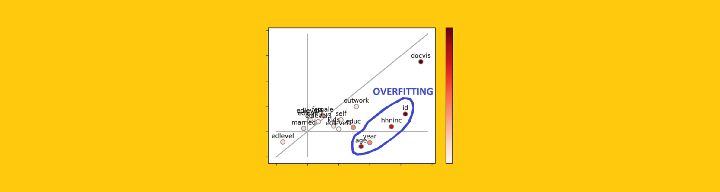

Machine learning에서 가장 중요한 것은 새로운 데이터에 대해 훌륭한 예측을 해내는 것입니다.

훈련 데이터에서는 예측을 잘하지만, 테스트 데이터에서는 좋지 않은 경우 모델이 **"overfitting"** 되었다고 합니다. 이는 모델이 훈련 데이터에서 너무 많은 노이즈 패턴을 학습했기 때문에 이전에 본 적이 없는 데이터에 잘 일반화될 수 없음을 의미합니다.

모델이 새 데이터에 대해 잘 일반화되지 않도록 하는 features은 무엇일까요?

이 아티클에서는 이 질문에 답하는 advanced method을 살펴보겠습니다.

# Feature importance won’t save you this time!
위 질문에 대한 답변이 "feature importance를 살펴보겠습니다"였다면 더 노력해야 될 것입니다.

> feature importance는 features가 새 데이터에서 어떤 성능을 보여주는지에 대해 전혀 말해주지 않습니다.

사실, 이는 모델이 훈련 단계에서 학습한 프록시일 뿐입니다. 모델이 feature 'Age'에 대해 많은 패턴을 학습했다면, 이 feature는 feature importance에서 높은 순위를 차지할 것입니다. 이것은 그 패턴이 정확한지 아닌지에 대해 의미하는 것이 아닙니다.(정확하다는 것은 새 데이터에도 적용할 수 있을 만큼 충분히 일반적인 패턴을 의미합니다).

따라서, 문제를 해결하려면 다른 접근 방식이 필요합니다.

# “There once was a German hospital…”
접근 방식을 설명하기 위해 1984년부터 1988년까지 독일 보건 레지스트리의 기록이 포함된 데이터 세트를 사용하겠습니다.

In [4]:
import pydataset
X = pydataset.data("rwm5yr")
y = (X["hospvis"] > 1).astype(int)
X = X.drop("hospvis", axis=1)

이 데이터 세트는 19,609개의 행으로 구성되어 있으며 각 행에는 해당 연도의 환자에 대한 일부 정보가 포함되어 있습니다. 환자는 다른 연도에 걸쳐 관찰되므로 동일한 환자가 데이터 프레임의 다른 행에서 발견될 수 있습니다.

target variable은 다음과 같습니다:

- **hospvis**: 해당 연도에 환자가 1일 이상 입원했는지 여부

또한, 16개 칼럼으로 구성되어 있습니다:

1. **id**: 환자 ID (1-7028)
2. **docvis**: 연중 의사 방문 횟수 (0-121)
3. **year**: 연도 (1984-1988)
4. **edlevel**: 교육 수준 (1-4)
5. **age**: 나이 (25-64)
6. **outwork**: 직업이 없으면 1, 아니면 0
7. **female**: 여성이면 1, 아니면 0
8. **married**: 결혼을 했으면 1, 아니면 0
9. **kids**: 자식이 있으면 1, 아니면 0
10. **hhninc**: 가계의 연간 소득
11. **educ**: 정규 교육 기간 (7-18)
12. **self**: 자영업인 경우 1, 아니면 0
13. **edlevel1**: 고등교육 미만이면 1, 아니면 0
14. **edlevel2**: 고졸이면 1, 아니면 0
15. **edlevel3**: 대학인 경우 1, 아니면 0
16. **edlevel4**: 대학원은 1, 아니면 0

데이터를 훈련 세트와 테스트 세트로 분리해 보겠습니다. cross-validation과 같은 보다 정교한 방법이 있지만, 간단하게 해봅니다. 이는 실험이기 때문에 모든 칼럼을 numeric features으로 취급합니다.

In [9]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    stratify=y)

cat = CatBoostClassifier(silent=True).fit(X_train, y_train)

모델이 학습되었기 때문에, feature importance를 살펴보겠습니다:

In [10]:
import pandas as pd
fimpo = pd.Series(cat.feature_importances_, index=X_train.columns)

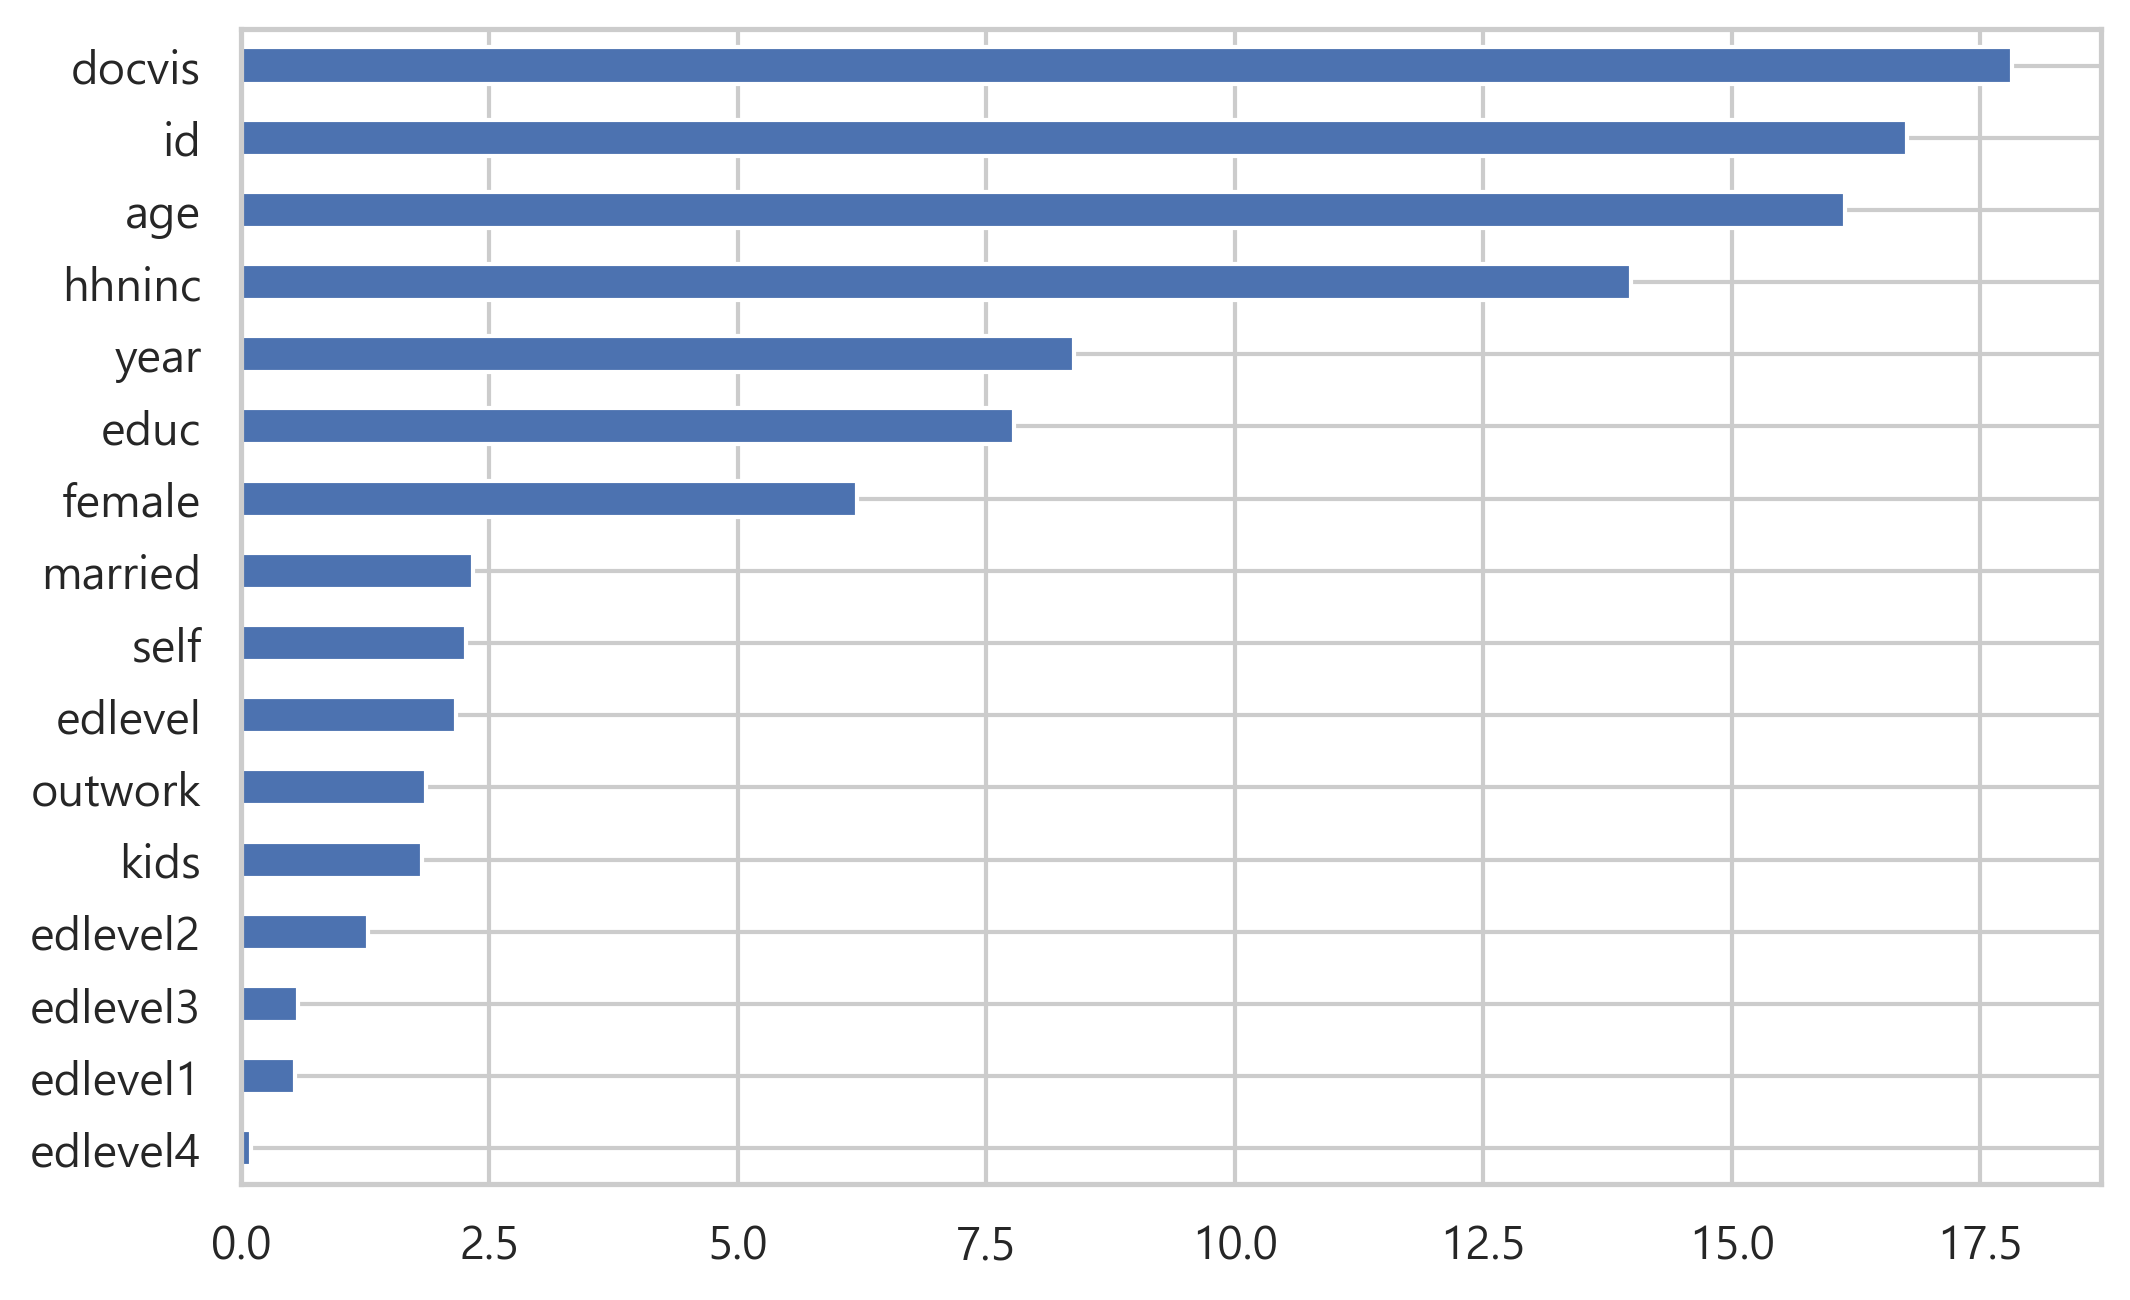

In [11]:
fimpo = pd.Series(cat.feature_importances_, index = X_train.columns)
fig, ax = plt.subplots()
fimpo.sort_values().plot.barh(ax=ax)
fig.savefig('fimpo.png', dpi = 200, bbox_inches="tight")
fig.show()

당연히 의사를 방문한 횟수인 ```docvis```는 환자가 병원에서 하루 이상을 보냈는지 여부를 예측하는 데 중요합니다. 또한 'age'와 'hhninc'(소득)도 다소 당연해 보입니다. 하지만, 환자의 id가 중요도에서 2순위라는 사실은 우리를 의심하게 만듭니다.

이제 훈련 세트와 테스트 세트 모두에서 모델 성능(ROC)을 계산해 보겠습니다.

In [13]:
from sklearn.metrics import roc_auc_score
roc_train = roc_auc_score(y_train, cat.predict_proba(X_train)[:, 1])
roc_test = roc_auc_score(y_test, cat.predict_proba(X_test)[:, 1])

print('\n################# Print roc')
print('roc_auc train: {:.2f}'.format(roc_train))
print('roc_auc  test: {:.2f}'.format(roc_test))


################# Print roc
roc_auc train: 0.97
roc_auc  test: 0.74


엄청난 차이입니다. 이는 강력한 overfitting의 증거입니다. 하지만, 어떤 feature가 이에 대해 책임이 있을까요?"

# Ever heard of SHAP values?
모델이 일부 데이터에 대해 성능을 측정하기 위한 많은 metrics가 있습니다. 하지만, 일부 데이터에서 features가 어떤 성능을 보여주는지 어떻게 측정할까요?

이를 수행하는 가장 강력한 도구를 "SHAP values"라고 합니다.

일반적으로 모든 예측 모델에 대한 SHAP values을 효율적으로 계산하기 위해 Python 라이브러리를 사용할 수 있습니다. 하지만, 이 예에서는 Catboost의 기본 method을 활용합니다.

In [34]:
from catboost import Pool

shap_train = pd.DataFrame(
    data=cat.get_feature_importance(data=Pool(X_train), 
                                    type="ShapValues")[:, :-1], # return shape이 (row, feature + 1)
    index=X_train.index,
    columns=X_train.columns
)

shape_test = pd.DataFrame(
    data=cat.get_feature_importance(data=Pool(X_test),
                                    type="ShapValues")[:, :-1],
    index=X_test.index,
    columns=X_test.columns
)

print('\n################# Print df shapes')
print(f'X_train.shape:    {X_train.shape}')
print(f'X_test.shape:     {X_test.shape}\n')
print(f'shap_train.shape: {shap_train.shape}')
print(f'shap_test.shape:  {shap_test.shape}')


################# Print df shapes
X_train.shape:    (15687, 16)
X_test.shape:     (3922, 16)

shap_train.shape: (15687, 16)
shap_test.shape:  (3922, 16)


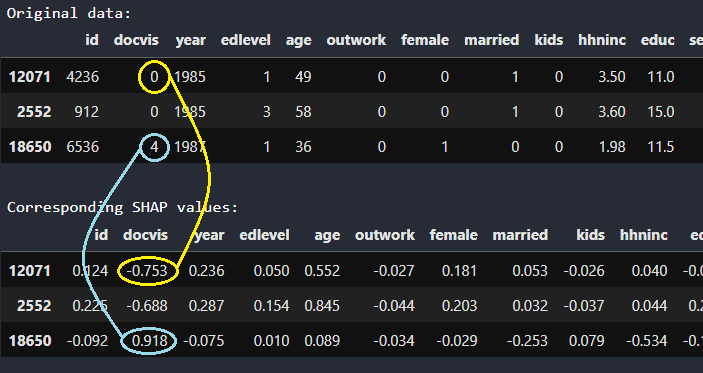

행 12071의 환자는 0번의 방문이 있었습니다. 해당 SHAP values(-0.753)는 이 정보가 그가 병원에 1일 이상 있었을 확률(실제로는 log-odds)이 -0.753만큼 낮음을 알려줍니다. 반대로, 행 18650의 환자는 의사에게 4번 방문했으며, 이는 그녀가 1일 이상 병원에 입원했다는 로그 확률을 0.918만큼 높입니다.

# Meeting ParShap
직관적으로 데이터 세트의 feature performance에 대한 좋은 proxy는 feature의 SHAP values와 target variable 간의 상관 관계입니다. 사실, 모델이 feature에서 좋은 패턴을 발견했다면 해당 feature의 SHAP values는 target variable와 강한 양의 상관관계가 있어야 합니다.

예를 들어, 'docvis' feature와 테스트 세트에 포함된 target variable 간의 상관 관계를 계산하려는 경우:

In [ ]:
np.corrcoef(shap_test['docvis'], y_test)

그러나 SHAP 값은 가산적입니다. 즉, 최종 예측은 모든 features의 SHAP values의 합입니다. 따라서, 상관 관계를 계산하기 전에, 다른 feature의 영향을 제거하는 것이 더 합리적입니다. 이것이 바로 "부분 상관관계(partial correlation)"의 정의입니다. 부분 상관관계의 쉬운 구현은 Python 라이브러리 Pingouin에 포함되어 있습니다.

In [40]:
import pingouin

pingouin.partial_corr(
    data=pd.concat([shap_test, y_test], axis=1).astype(float),
    x="docvis",
    y=y_test.name,
    x_covar=[feature for feature in shap_test.columns if feature != "docvis"]
)

,n,r,CI95%,p-val
pearson,3922,0.145262,"[0.11, 0.18]",7.155080e-20


이 코드 조각은 "다른 모든 feature의 영향을 제거한 후, 테스트 세트의 observation에서 feature ```docvis```의 SHAP values와 target variable 간의 상관 관계를 계산"하는 것을 의미합니다.

모든 것은 명칭이 필요하므로 이 공식을 "ParShap"(Shap values의 부분 상관 관계(Partial Correlation)이라고 부를 것입니다.

훈련 세트와 테스트 세트 모두에서 각 feature에 대해 이 절차를 반복할 수 있습니다.

In [43]:
def partial_correlation(X, y):
    out = pd.Series(index=X.columns, dtype=float)
    for feature_name in X.columns:
        out[feature_name] = pingouin.partial_corr(data=pd.concat([X, y], axis=1).astype(float), 
                                                  x=feature_name, 
                                                  y=y.name,
                                                  x_covar=[f for f in X.columns if f != feature_name] ).loc['pearson', 'r']
    return out

parshap_train = partial_correlation(shap_train, y_train)
parshap_test = partial_correlation(shap_test, y_test)

이제 ```parshap_train```을 x축, ```parshap_test```를 y축에 놓고 plot을 생성해봅니다.

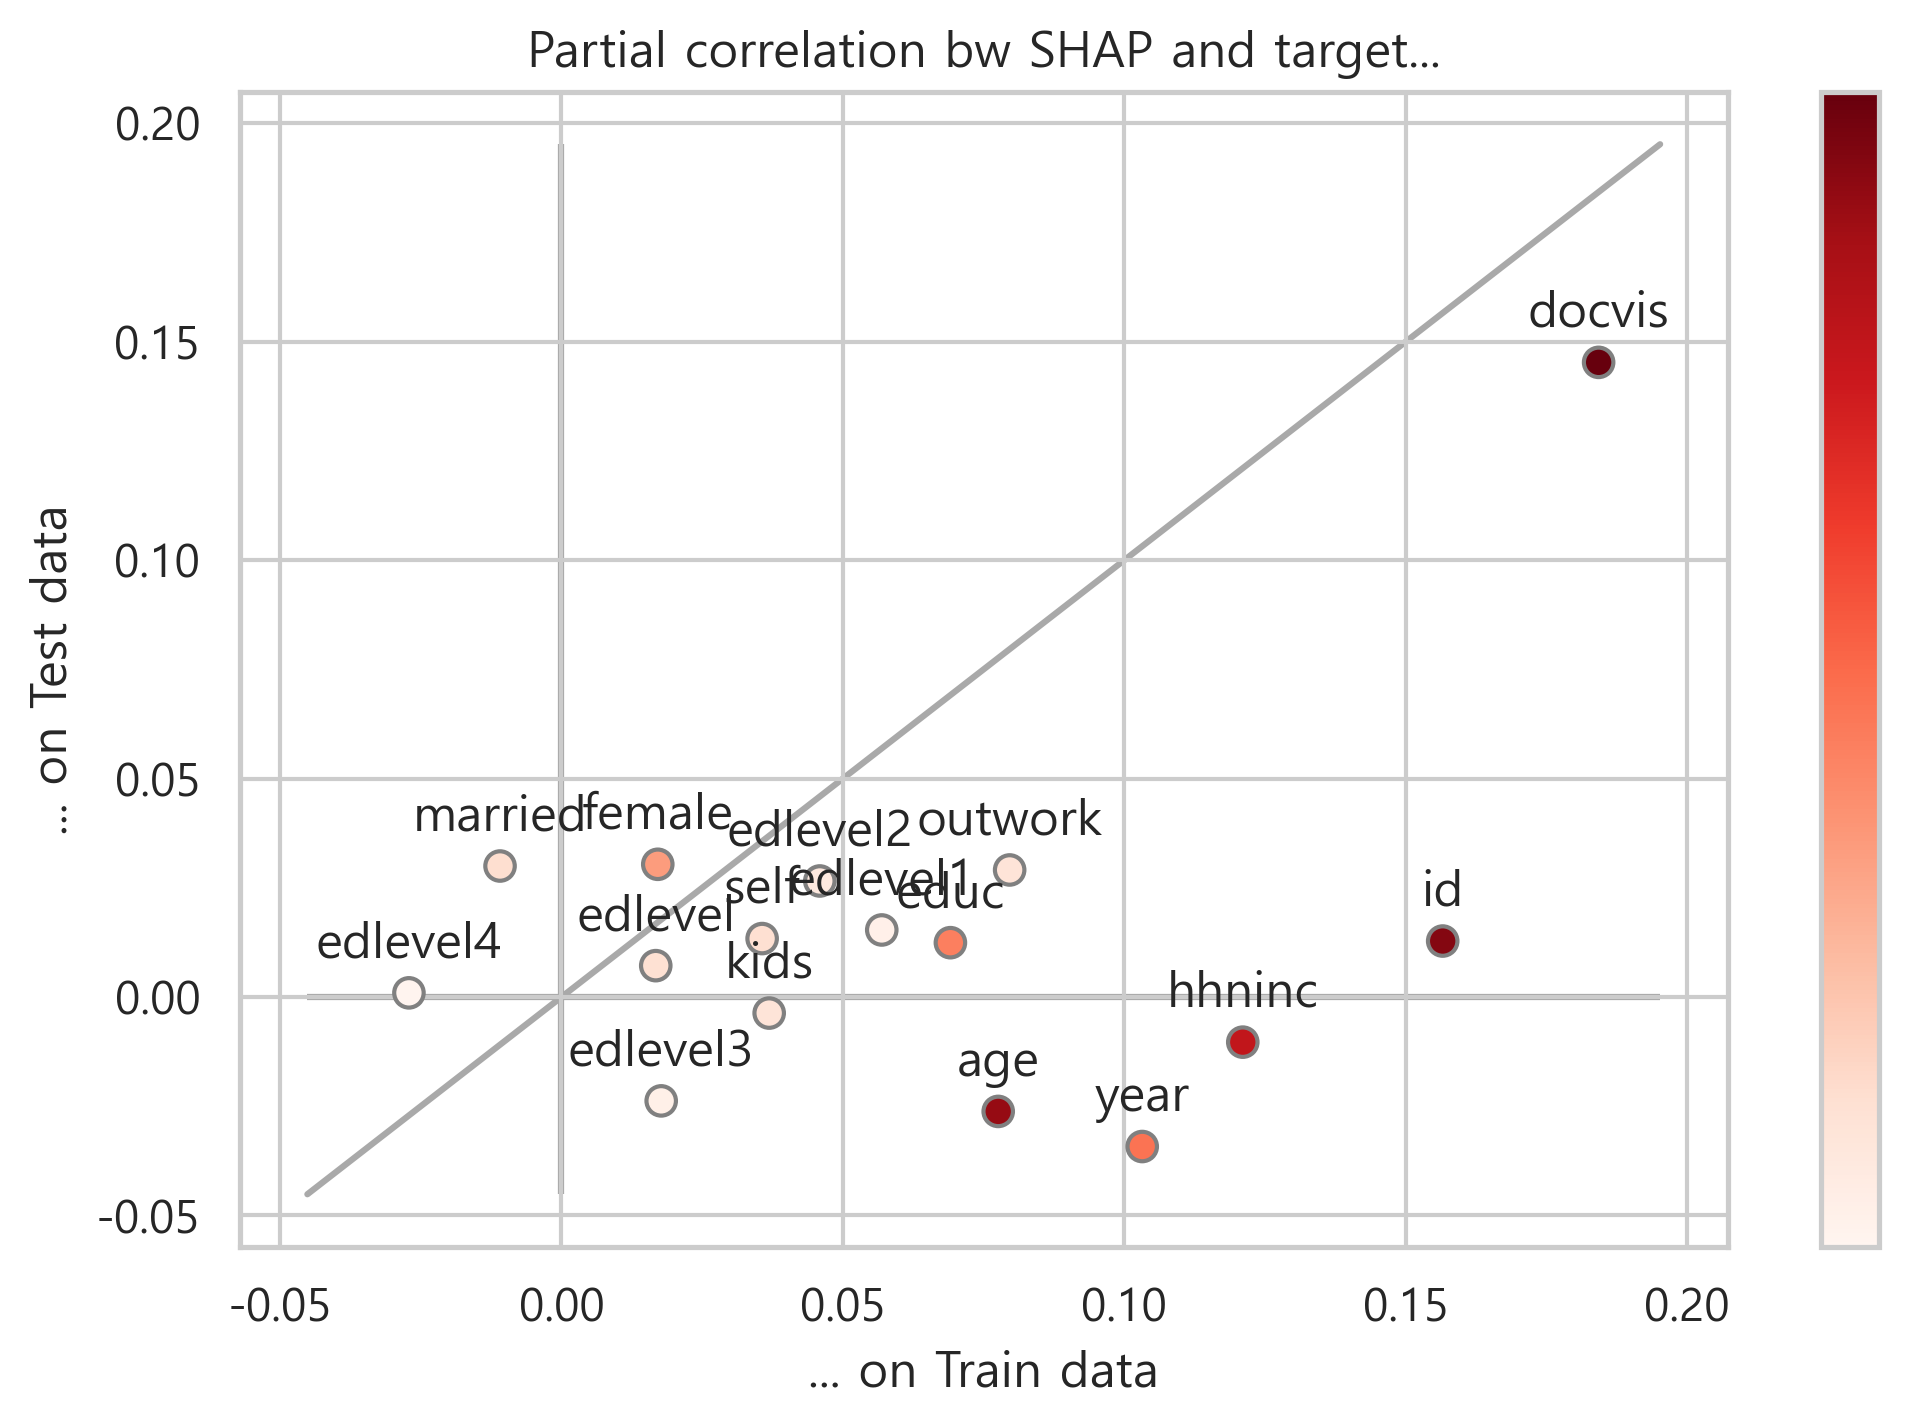

In [51]:
# Plot parshap
plotmin, plotmax = min(parshap_train.min(), parshap_test.min()), max(parshap_train.max(), parshap_test.max())
plotbuffer = .05 * (plotmax - plotmin)
fig, ax = plt.subplots()
if plotmin < 0:
    ax.vlines(0, plotmin - plotbuffer, plotmax + plotbuffer, color='darkgrey', zorder=0)
    ax.hlines(0, plotmin - plotbuffer, plotmax + plotbuffer, color='darkgrey', zorder=0)
ax.plot(
    [plotmin - plotbuffer, plotmax + plotbuffer], [plotmin - plotbuffer, plotmax + plotbuffer], 
    color='darkgrey', zorder=0
)
sc = ax.scatter(
    parshap_train, parshap_test, 
    edgecolor='grey', c=fimpo, s=50, cmap=plt.cm.get_cmap('Reds'), vmin=0, vmax=fimpo.max())
ax.set(title='Partial correlation bw SHAP and target...', xlabel='... on Train data', ylabel='... on Test data')
cbar = fig.colorbar(sc)
cbar.set_ticks([])
for txt in parshap_train.index:
    ax.annotate(txt, (parshap_train[txt], parshap_test[txt] + plotbuffer / 2), ha='center', va='bottom')
fig.savefig('parshap.png', dpi=300, bbox_inches="tight")
fig.show()

Feature가 이등분선에 있으면 훈련 세트와 테스트 세트에서 정확히 동일하게 수행됨을 의미합니다. overfitting도 underfitting도 없는 이상적인 상황입니다. 반대로, feature가 이등분선 아래에 있으면 훈련 세트보다 테스트 세트에서 더 나쁜 성능을 보였다는 의미이므로 overfitting 영역입니다.

시각적으로 어떤 feaeture의 성능이 낮은지 즉시 알 수 있습니다. 파란색 원으로 표시했습니다.

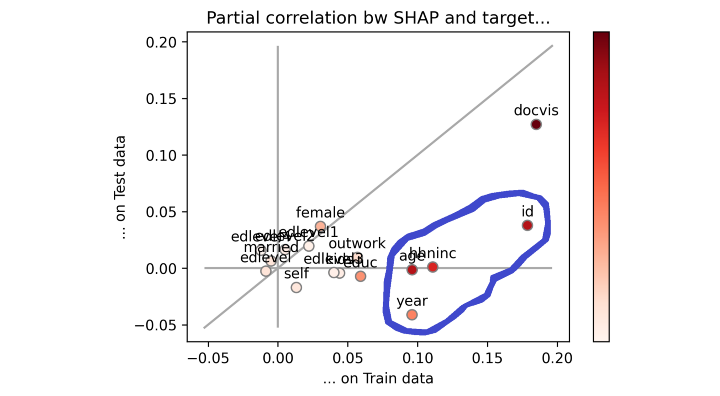

따라서, ```parshap_test```와 ```parshap_train```간의 산술적 차이(각 feature와 이등분선 사이의 수직 거리와 같음)는 우리 모델에 대해 feature가 얼마나 overfitting되는지를 측정합니다.

In [54]:
parshap_diff = pd.Series(parshap_test - parshap_train, name='parshap_diff')
print('\n################# Print parshap_diff')
pd.DataFrame(parshap_diff.sort_values())


################# Print parshap_diff


,parshap_diff
id,-0.143743
year,-0.137392
hhninc,-0.131368
age,-0.103771
educ,-0.056658
outwork,-0.050539
edlevel1,-0.041553
edlevel3,-0.041487
kids,-0.040575
docvis,-0.038996


이 output을 어떻게 해석해야 할까요? 위의 점수가 더 부정적일수록 feature에 의해 더 많이 overfitting됩니다.

# “I don’t believe you”
괜찮습니다. 이 아티클의 직관이 맞는지 어떻게 알 수 있을까요?

논리적으로 데이터 세트에서 "overfitting features"을 제거하면 overfitting(즉, ```roc_train```과 ```roc_test``` 사이의 거리)을 줄일 수 있어야 합니다.

따라서, 한 번에 하나의 feature를 삭제하고 ,ROC가 어떻게 변경되는지 살펴보겠습니다.

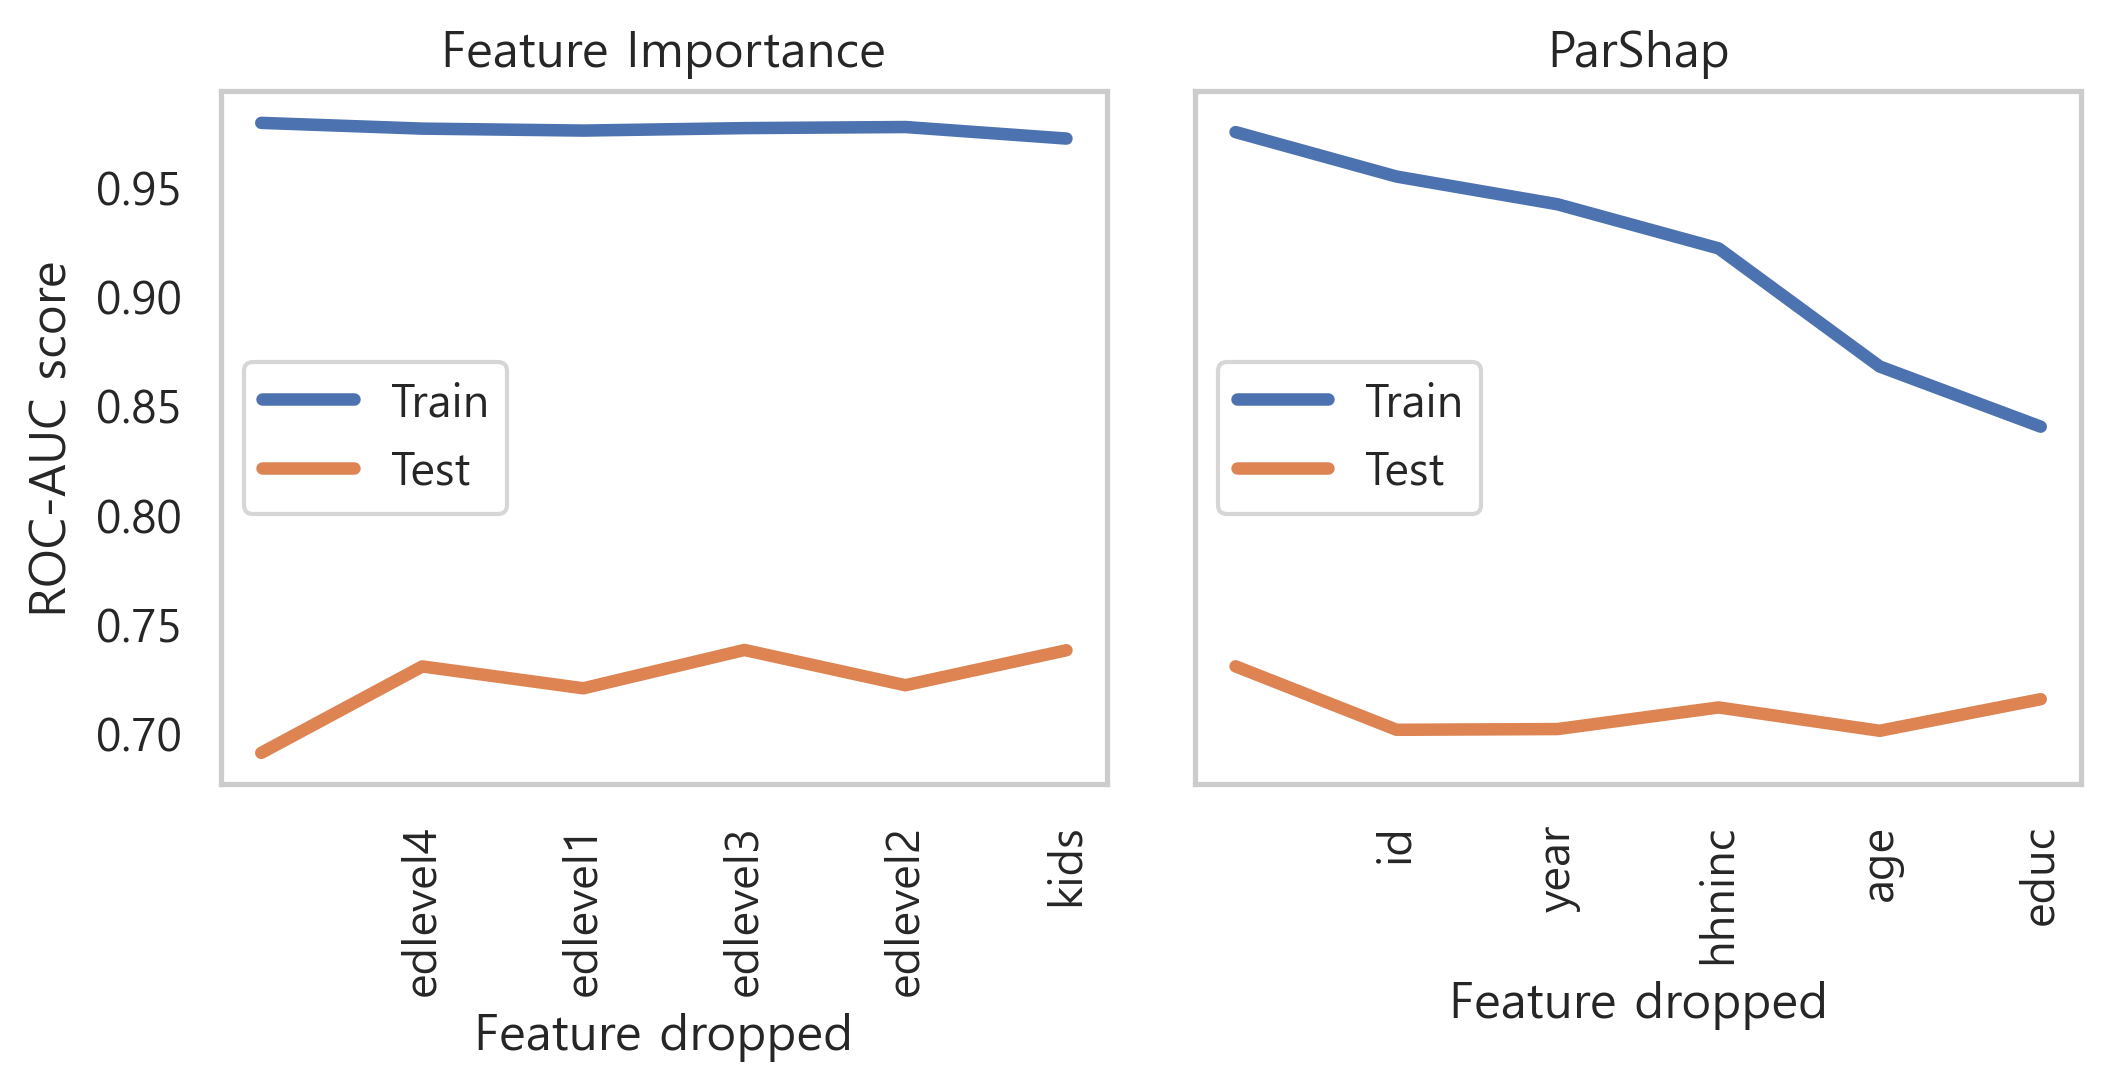

In [58]:
# Feature selection
n_drop_max = 5
iterations = 4
features = {'parshap': parshap_diff, 'fimpo': fimpo}
features_dropped = {}
roc_auc_scores = {
  'fimpo': {'train': pd.DataFrame(), 'test': pd.DataFrame()},
  'parshap': {'train': pd.DataFrame(), 'test': pd.DataFrame()}
}
for type_ in ['parshap', 'fimpo']:
    for n_drop in range(n_drop_max + 1):
        features_drop = features[type_].sort_values().head(n_drop).index.to_list()
        features_dropped[type_] = features_drop
        X_drop = X.drop(features_drop, axis=1)
        for i in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=.2, stratify=y)
            cat = CatBoostClassifier(silent = True).fit(X_train, y_train)
            roc_auc_scores[type_]['train'].loc[n_drop, i] = roc_auc_score(y_train, cat.predict_proba(X_train)[:, 1])
            roc_auc_scores[type_]['test'].loc[n_drop, i] = roc_auc_score(y_test, cat.predict_proba(X_test)[:, 1])
        
# Plot feature selection
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
plt.subplots_adjust(wspace=.1)
axs[0].plot(roc_auc_scores['fimpo']['train'].index, roc_auc_scores['fimpo']['train'].mean(axis=1), lw=3, label='Train')
axs[0].plot(roc_auc_scores['fimpo']['test'].index, roc_auc_scores['fimpo']['test'].mean(axis=1), lw=3, label='Test')
axs[0].set_xticks(roc_auc_scores['fimpo']['train'].index)
axs[0].set_xticklabels([''] + features_dropped['fimpo'], rotation=90)
axs[0].set_title('Feature Importance')
axs[0].set_xlabel('Feature dropped')
axs[0].grid()
axs[0].legend(loc='center left')
axs[0].set(ylabel='ROC-AUC score')
axs[1].plot(roc_auc_scores['parshap']['train'].index, roc_auc_scores['parshap']['train'].mean(axis=1), lw=3, label='Train')
axs[1].plot(roc_auc_scores['parshap']['test'].index, roc_auc_scores['parshap']['test'].mean(axis=1), lw=3, label='Test')
axs[1].set_xticks(roc_auc_scores['parshap']['train'].index)
axs[1].set_xticklabels([''] + features_dropped['parshap'], rotation=90)
axs[1].set_title('ParShap')
axs[1].set_xlabel('Feature dropped')
axs[1].grid()
axs[1].legend(loc='center left')
fig.savefig('feature_selection.png', dpi=300, bbox_inches="tight")
fig.show()

왼쪽은 feature importance에 따라 정렬하여 한 번에 하나의 feature를 제거하고 있습니다. 따라서 먼저 가장 덜 중요한(```edlevel4```)가 제거된 다음 두 개의 가장 덜 중요한(```edlevel4``` 과 ```edlevel1```)이 제거되는 식입니다.

오른쪽도 동일한 과정을 따르고 있지만, 제거 순서는 ParShap에서 의해 결정됩니다. 따라서, 먼저 가장 negative인 ParShap(```id```)가 제거된 다음 가장 negative인 두 ParShap(```id``` 및 ```year```)이 제거되는 식입니다.

기대했던 대로 가장 negative인 ParShap으로 feature를 삭제하면 overfitting이 크게 감소했습니다. 실제로 ```roc_train```은 ```roc_test```에 점점 더 가까워지고 있습니다.

지금까지 이것은 우리의 추론 과정의 정확성을 확인하기 위한 테스트일 뿐입니다. 일반적으로 ParShap은 feature selection을 위한 방법으로 사용되어서는 안 됩니다. 일부 feature가 overfitting되기 쉽다는 사실이 해당 feature가 유용한 정보를 전혀 전달하지 않는다는 것을 의미하지는 않기 때문입니다. (예를 들어, 이 예에서는 income과 age).

그러나, ParShap은 모델을 디버깅하는 방법에 대한 힌트를 제공하기 때문에 매우 유용하고, 더 많은 feature engineering 또는 regularization가 더 필요한 feature에 주의를 집중할 수 있게 해줍니다.